In [3]:
library(tidyverse)
library(repr)
library(infer)
library(dplyr)
library(broom)

set.seed(1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [4]:
bike_day_data <- read_csv("https://raw.githubusercontent.com/megannma/stat-201-2023s2-group-10/main/day.csv")
head(bike_day_data)

Rows: 731 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (15): instant, season, yr, mnth, holiday, weekday, workingday, weathers...
date  (1): dteday

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.1604460,331,654,985
2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.2485390,131,670,801
3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.2483090,120,1229,1349
4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.1602960,108,1454,1562
5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.1869000,82,1518,1600
6,2011-01-06,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.0895652,88,1518,1606


In [5]:
selected_bike_day_data <-
    bike_day_data %>%
    select(season, workingday, temp, casual, registered, cnt) %>%
    mutate(season = as.factor(season), workingday = as.factor(workingday))
head(selected_bike_day_data)

season,workingday,temp,casual,registered,cnt
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0.344167,331,654,985
1,0,0.363478,131,670,801
1,1,0.196364,120,1229,1349
1,1,0.200000,108,1454,1562
1,1,0.226957,82,1518,1600
1,1,0.204348,88,1518,1606


In [6]:
set.seed(1)
# Clean and wrangle the data for working vs nonworking days
workingday_data_clean <- selected_bike_day_data |>
    select(workingday, cnt)

levels(workingday_data_clean$workingday) <- c("no","yes")

# Stats are summarized
workingday_data_stats <- workingday_data_clean |>
    select(workingday, cnt) |>
    group_by(workingday) |> 
    summarise(n = n(),
              mean = mean(cnt),
              sd = sd(cnt),
              median = median(cnt))
workingday_data_stats

# Assign the statistical values need for analysis to distinct variables

## Means
working_x_bar <- workingday_data_stats$mean[2]
nonworking_x_bar <- workingday_data_stats$mean[1]

## Variations
working_var <- workingday_data_stats$sd[2]^2
nonworking_var <- workingday_data_stats$sd[1]^2

## Size n
working_n <- workingday_data_stats$n[2]
nonworking_n <- workingday_data_stats$n[1]

## Mean Difference
mean_diff_days <- working_x_bar - nonworking_x_bar

## Standard Error
std_error_days <- sqrt((working_var/working_n)+(nonworking_var/nonworking_n))

workingday,n,mean,sd,median
<fct>,<int>,<dbl>,<dbl>,<dbl>
no,231,4330.169,2052.141,4459
yes,500,4584.820,1878.416,4582


- We now create a tibble containing the mean differences and their associated densities obtained by the Central Limit Theorem for working vs nonworking days, and assign it to an object called clt_samp_dist_workingdays.


In [ ]:
set.seed(1)
# Plot the bootstrap sampling distribution vs the CLT estimates
# Create a tibble to plot the normal curve
clt_samp_dist_workingdays <- 
    tibble(x = seq(mean_diff_days - 4 * std_error_days, 
                   mean_diff_days + 4 * std_error_days, 
                   0.0001),
           density = dnorm(x, mean_diff_days, std_error_days))

# Obtain the boostrap sampling distribution
workingdays_btsp_samp_distribution <- workingday_data_clean %>%
    specify(formula = cnt ~ workingday) %>%
    generate(reps = 1000, size = 100, type = "bootstrap") %>%
    calculate(stat = "diff in means", order = c("yes", "no"))

# Let's plot the bootstrap vs the CLT estimates
working_btsp_vs_clt_samp_dist_plot <- 
    workingdays_btsp_samp_distribution %>% 
    ggplot() + 
    geom_histogram(aes(x = stat, ..density..), color = 'white') + 
    geom_line(data = clt_samp_dist_workingdays, aes(x, density), lwd = 2, color = "red") + 
    xlab("Difference in means of total users for Working vs Nonworking days ") + 
    ggtitle("bootstrap distribution reps = 1000 vs CLT line") + 
    theme(text = element_text(size = 20))


working_btsp_vs_clt_samp_dist_plot

p_value
<dbl>
0.088


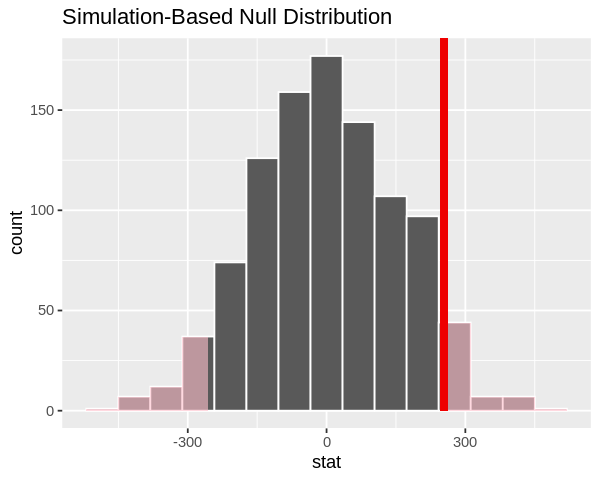

In [ ]:
set.seed(1)
# Set the graph settings
options(repr.plot.width=5, repr.plot.height=4)

# Obtain the null distribution
null_workingdays_distribution <- workingday_data_clean %>%
    specify(formula = cnt ~ workingday) %>%
    hypothesize(null = "independence") %>%
    generate(reps = 1000, type = "permute") %>%
    calculate(stat = "diff in means", order = c("yes", "no"))

# Compute the observed difference in means
obs_diff_means <- workingday_data_clean %>%
    specify(cnt ~ workingday) %>%
    calculate(stat = "diff in means", order = c("yes", "no"))

# Visualize the p-value on null distribution
visualize(null_workingdays_distribution) + 
  shade_p_value(obs_stat = obs_diff_means, direction = "both")

# Obtain the p-value
null_workingdays_distribution %>% 
  get_p_value(obs_stat = obs_diff_means, direction = "both")

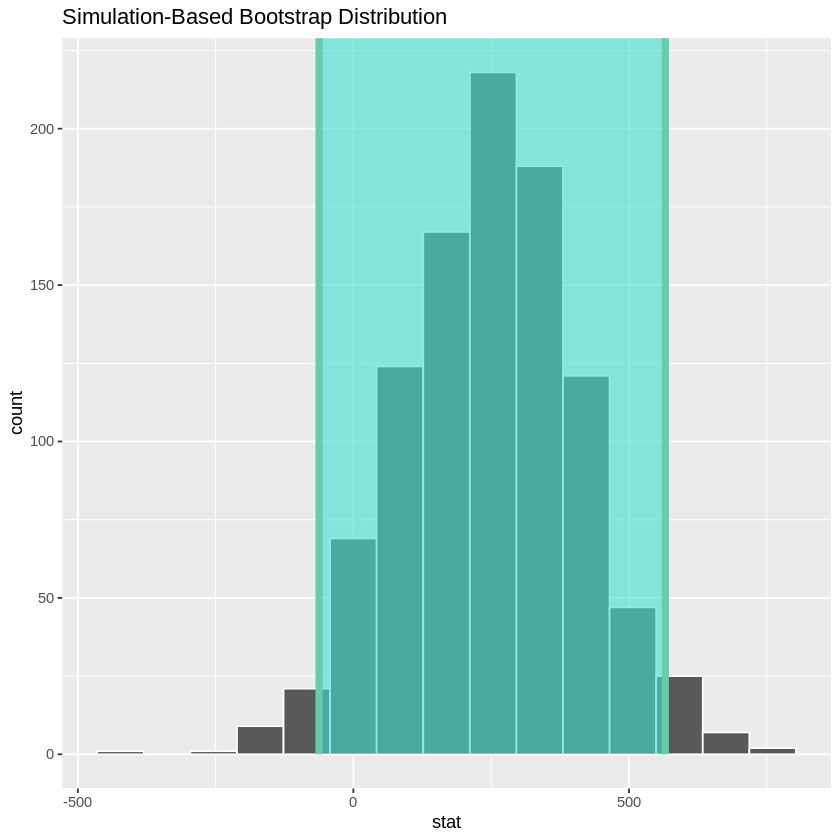

In [52]:
# Create the corresponding bootstrap distribution to construct a 95% confidence interval for the difference in means
bootstrap_workingdays_distribution <- workingday_data_clean %>%
    specify(formula = cnt ~ workingday) %>%
    generate(reps = 1000, type = "bootstrap") %>%
    calculate(stat = "diff in means", order = c("yes", "no"))

# Obtain the lower and upper quantiles for a 95% confidence interval using the bootstrap distribution
ci_workingdays <- bootstrap_workingdays_distribution %>%
    get_ci(0.95, "percentile")

# Visualize the 95% confidence interval
visualize(bootstrap_workingdays_distribution) + 
  shade_confidence_interval(endpoints = ci_workingdays)